In [1]:
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 150)
sns.set_style('darkgrid')
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (10, 6)
matplotlib.rcParams['figure.facecolor'] = '#00000000'

In [3]:
train_input = pd.read_csv('train_inputs.csv')
val_input = pd.read_csv('val_inputs.csv')
test_input = pd.read_csv('test_inputs.csv')

print(train_input.shape, val_input.shape, test_input.shape)

(97988, 118) (17089, 118) (25710, 118)


In [4]:
train_targets = pd.read_csv('train_targets.csv')
val_targets = pd.read_csv('val_targets.csv')
test_targets = pd.read_csv('test_targets.csv')


print(train_targets.shape, val_targets.shape, test_targets.shape)

(97988, 2) (17089, 2) (25710, 2)


In [5]:
train_targets.drop('Unnamed: 0', axis=1, inplace=True)
val_targets.drop('Unnamed: 0', axis=1, inplace=True)
test_targets.drop('Unnamed: 0', axis=1, inplace=True)

In [28]:
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestClassifier

In [13]:
model = RandomForestClassifier(n_jobs=-1, random_state=42)

In [14]:
%%time
model.fit(train_input, train_targets)

<timed eval>:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


CPU times: user 50.9 s, sys: 668 ms, total: 51.5 s
Wall time: 8.72 s


RandomForestClassifier(n_jobs=-1, random_state=42)

In [15]:
base_train_acc = model.score(train_input, train_targets)
base_val_acc = model.score(val_input, val_targets)

base_acc = base_train_acc, base_val_acc
base_acc 

(0.9999897946687349, 0.8578032652583534)

In [16]:
train_prob = model.predict_proba(train_input)
train_prob

array([[0.9 , 0.1 ],
       [0.94, 0.06],
       [0.96, 0.04],
       ...,
       [0.98, 0.02],
       [0.98, 0.02],
       [0.93, 0.07]])

In [32]:
len(model.estimators_)

100

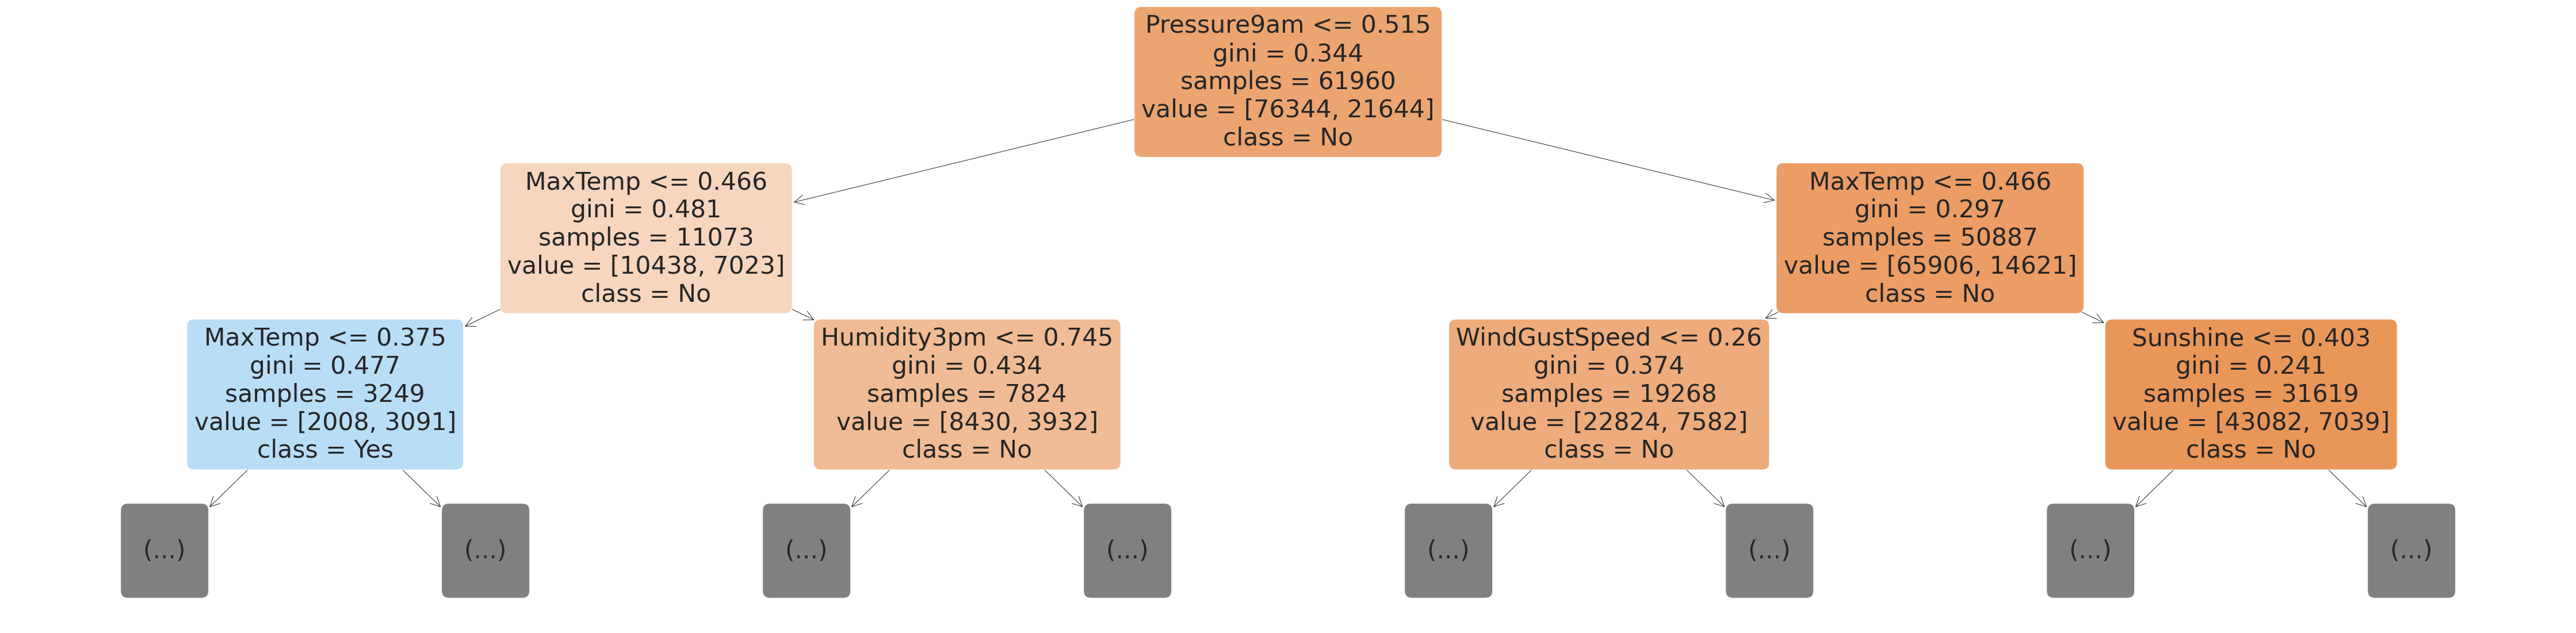

In [31]:
plt.figure(figsize=(80, 20))
plot_tree(model.estimators_[0], max_depth=2, feature_names=train_input.columns, filled=True, rounded=True, class_names=model.classes_);

In [36]:
important_df = pd.DataFrame({
                            'features': train_input.columns,
                            'important': model.feature_importances_
}).sort_values('important', ascending=False)

important_df.head(10)

,features,important
10,Humidity3pm,0.144553
5,Sunshine,0.055714
12,Pressure3pm,0.054408
9,Humidity9am,0.049863
11,Pressure9am,0.048601
3,Rainfall,0.047188
6,WindGustSpeed,0.046977
2,MaxTemp,0.045145
0,Unnamed: 0,0.043495
1,MinTemp,0.041212


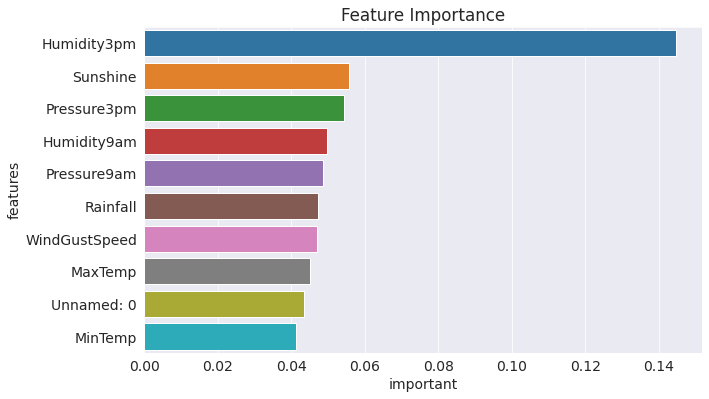

In [37]:
plt.title('Feature Importance')
sns.barplot(data=important_df.head(10), x='important', y='features');

### Random Forest Hyperparameter Tuning
1. __`n_estimator`__ 
    - used to control the #trees in RandomForest
    - increases the randomness of the model and there avoid overfitting
    - 

2. __`max_depth`__
    - reduces overfitting by reducing the depth of the trees
    - in a way reducing the complexity of the model
    -

3. __`max_features`__
    - instead of picking every feature(columns) for every split, we can specify only a fraction of featuers to be chosen randomly 
    -

4. __`min_sample_split`__ & __`min_sample_leaf`__
    - min_sample_split --> node splits only if it `> x` number of columns 
    - min_sample_leaf --> node splits into leaves only if there are `> y` leaves
    -  

5. __`min_impurity_decrease`__
    - controls the threshold for splitting nodes, i.e. if the change is ` < z` then the nodes won't split
    - if the threshold is set too large then it might lead to high bias
    - In this example, the best threshold is `1e-6`
    - 

6. __`bootstrap`__, __`max_sample`__
    - By default Decision Trees don't use the entire dataset for training a decision tree. Instead, it selects a set of rows from the dataset randomly with replacement, i.e. some rows might not show up at all while other maybe repeated 
    - This is called __Bootstrapping__. And it helps in generalization
    - By default bootstraping is enabled in Random Forest
    - When bootstrapping is enabled, `max_sample` can be used to control the fraction of rows to be considered for each bootstrap
    - 

In [42]:
# testing various values of n_estimators

%%time
for i in (10, 200, 500):
    model_ = RandomForestClassifier(random_state=42, n_jobs=-1, n_estimators=i);
    model.fit(train_input, train_targets);
    c = {'train_score':model.score(train_input, train_targets), 'val_score': model.score(val_input, val_targets)}
    print('<n_estimators=', i,'>')
    print(c)
    print(base_acc)
    print('\n')

<timed exec>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


n_estimators= 10
{'train_score': 1.0, 'val_score': 0.8582128854818889}
(0.9999897946687349, 0.8578032652583534)




<timed exec>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


n_estimators= 200
{'train_score': 1.0, 'val_score': 0.8582128854818889}
(0.9999897946687349, 0.8578032652583534)




<timed exec>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


n_estimators= 500
{'train_score': 1.0, 'val_score': 0.8582128854818889}
(0.9999897946687349, 0.8578032652583534)


CPU times: user 5min 58s, sys: 2.96 s, total: 6min 1s
Wall time: 1min 1s


In [46]:
# Helper Function 

def test_params(**params):
    model = RandomForestClassifier(random_state=42, n_jobs=-1, **params).fit(train_input, train_targets)
    print(model.score(train_input, train_targets))
    print(model.score(val_input, val_targets))

In [50]:
# Testing max_depths = 5, 25

test_params(max_depth=5)

test_params(max_depth=25)

/tmp/ipykernel_13028/1922171912.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model = RandomForestClassifier(random_state=42, n_jobs=-1, **params).fit(train_input, train_targets)


0.8258562272931379
0.8305927789806308


/tmp/ipykernel_13028/1922171912.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model = RandomForestClassifier(random_state=42, n_jobs=-1, **params).fit(train_input, train_targets)


0.9785585990121239
0.8573936450348177


In [51]:
# Testing max_features = log2, 3, 6, sqrt(n)[default]

test_params(max_features='log2')

test_params(max_features=3)

test_params(max_features=6)

/tmp/ipykernel_13028/1922171912.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model = RandomForestClassifier(random_state=42, n_jobs=-1, **params).fit(train_input, train_targets)


1.0
0.8576862309087717


/tmp/ipykernel_13028/1922171912.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model = RandomForestClassifier(random_state=42, n_jobs=-1, **params).fit(train_input, train_targets)


0.9999897946687349
0.8547018549944408


/tmp/ipykernel_13028/1922171912.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model = RandomForestClassifier(random_state=42, n_jobs=-1, **params).fit(train_input, train_targets)


1.0
0.8576862309087717


In [53]:
# Testing the min_samples_split & min_samples_leaf

test_params(min_samples_split=3, min_samples_leaf=2)
test_params(min_samples_split=100, min_samples_leaf=60)

/tmp/ipykernel_13028/1922171912.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model = RandomForestClassifier(random_state=42, n_jobs=-1, **params).fit(train_input, train_targets)


0.9623423276319549
0.8587395400550062


/tmp/ipykernel_13028/1922171912.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model = RandomForestClassifier(random_state=42, n_jobs=-1, **params).fit(train_input, train_targets)


0.8517471527125771
0.8465679676985195


In [54]:
# Testing the min_impurity_decrease

test_params(min_impurity_decrease=1e-7)
test_params(min_impurity_decrease=1e-3)

/tmp/ipykernel_13028/1922171912.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model = RandomForestClassifier(random_state=42, n_jobs=-1, **params).fit(train_input, train_targets)


0.9996530187369882
0.8592076774533326


/tmp/ipykernel_13028/1922171912.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model = RandomForestClassifier(random_state=42, n_jobs=-1, **params).fit(train_input, train_targets)


0.780309833857207
0.7926736497161917


In [55]:
# Bootstraping and max_samples

test_params(bootstrap=False)
test_params(max_samples=0.9)

/tmp/ipykernel_13028/1922171912.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model = RandomForestClassifier(random_state=42, n_jobs=-1, **params).fit(train_input, train_targets)


1.0
0.8585639885306338


/tmp/ipykernel_13028/1922171912.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model = RandomForestClassifier(random_state=42, n_jobs=-1, **params).fit(train_input, train_targets)


0.9998877413560844
0.8558721984902569
